## EFM: Toy experiments

In [1]:
import torch

import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("/trinity/home/a.kolesov/EFM/")
from src.data import MultiDimStackedGauss, MultiDimStackedMixtureGauss, SwissRollSampler
from src.utils import Config
from src.efm_field import EFM
from src.ode import DippoleGroundTrurthEFMODESolver,  LearnDippoleEFMODESolver
from src.models  import DefineMLP, ToyNet

import warnings
warnings.filterwarnings('ignore')

## 1. Gaussian to Mixture

In [2]:
config = Config()

##### common #####
config.device = 'cuda' 
config.DIM = 3
config.L = 6.

config.KV = {"z":[-5,5.], "x":[1e-5,8.], "y": [-8,8]}
config.mesh_num_points = 7
##### common ##### 

##### p_data #####
config.p = Config()
config.p.dim = config.DIM -1
config.p.mean = (0.,0.)
config.p.x_loc = 0.
config.p.std = 1.
config.p.cov = None
##### p_data #####

##### q_data #####
config.q =  Config()
config.q.dim = config.DIM -1
config.q.num_components = 2
config.q.mix_probs = (0.5,0.5)
config.q.means = ((-8.,0.),(8.,0.))
config.q.stds = (1.,1.)
config.q.cov = None
config.q.x_loc = config.L
##### q_data #####

##### EFM #####
config.training = Config()

config.training = Config()
config.training.stability = True
config.training.gamma = 1e-7
config.training.epsilon=0.3
config.training.interpolation='mesh'
config.training.M = 20.
config.training.tau = .08
config.training.sigma_end = .8
config.training.batch_size =2048
config.training.small_batch_size =1024
config.training.restrict_M = False
config.training.training_steps = 8000
##### EFM #####

config.ode = Config()
config.ode.step = 1.   
config.ode.gamma = 0.
config.ode.behind_step = 1.5
config.ode.behind_num_steps = 350

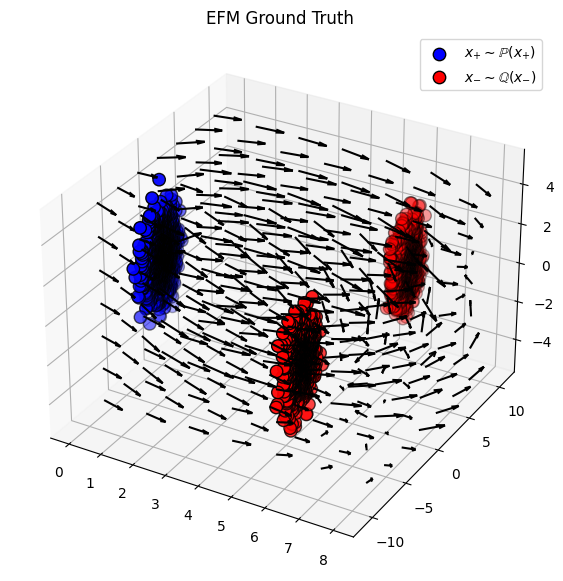

In [242]:
p_dist = MultiDimStackedGauss(config)
q_dist = MultiDimStackedMixtureGauss(config)

p_samples = p_dist.sample(config.training.batch_size).to(config.device)
q_samples = q_dist.sample(config.training.batch_size).to(config.device)
efm = EFM(config)

mesh = efm.get_mesh(kv=config.KV,
                    mesh_num_points=config.mesh_num_points).to(config.device)
field = efm.GroundTruth(perturbed_samples_vec=mesh.clone(),
                        p_samples=p_samples, q_samples=q_samples)

fig = efm.plotVectorField(mesh=mesh, field=field,
                          p_samples=p_samples,
                          q_samples=q_samples)

In [332]:
ode = DippoleGroundTrurthEFMODESolver(config)
init = p_dist.sample(config.training.small_batch_size).to(config.device)
init[:,0] = config.training.epsilon
maps, traj = ode(efm, init , p_samples.clone(), q_samples.clone())
traj = torch.stack(traj,dim=0)

100%|██████████| 350/350 [00:00<00:00, 1098.92it/s]


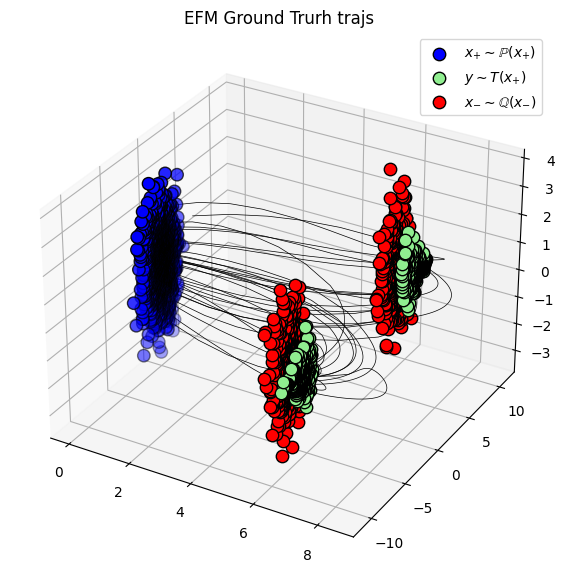

In [5]:
fig = efm.plotTrajectories(traj=traj, 
                           p_samples=p_samples,
                           q_samples=q_samples, title="EFM Ground Trurh trajs");

## 2. Gaussian to Swiss Roll

In [75]:
config = Config()

##### common #####
config.device = 'cuda' 
config.DIM = 3
config.L = 6.

config.KV = {"z":[-5,5.], "x":[1e-5,8.], "y": [-8,8]}
config.mesh_num_points = 7
##### common ##### 

##### p_data #####
config.p = Config()
config.p.dim = config.DIM -1
config.p.mean = (0.,0.)
config.p.x_loc = 0.
config.p.std = 1.
config.p.cov = None
##### p_data #####

##### q_data #####
config.q =  Config()
config.q.dim = config.DIM -1
config.q.x_loc = 6.
config.q.swiss_noise = None
##### q_data ##### 

##### EFM #####
config.training = Config()

config.training = Config()
config.training.stability = True
config.training.gamma = 1e-7
config.training.epsilon=0.3
config.training.interpolation='mesh'
config.training.M = 20.
config.training.tau = .08
config.training.sigma_end = .8
config.training.batch_size =2048
config.training.small_batch_size =1024
config.training.restrict_M = False
config.training.training_steps = 8000
##### EFM #####



config.model = Config()
config.model.embed_dim = 128
config.model.hidden_layers_x = [config.DIM-1, 1024*(config.DIM-1),
                                1024*(config.DIM-1),config.model.embed_dim]
config.model.hidden_layers = [ config.model.embed_dim, 1024*(config.DIM),
                              1024*(config.DIM), config.DIM]
config.model.lr =1e-4

##### ode #####
config.ode = Config()
config.ode.step = .5
config.ode.gamma = 0.
config.ode.behind_step = 1.5
config.ode.behind_num_steps = 350
##### ode #####

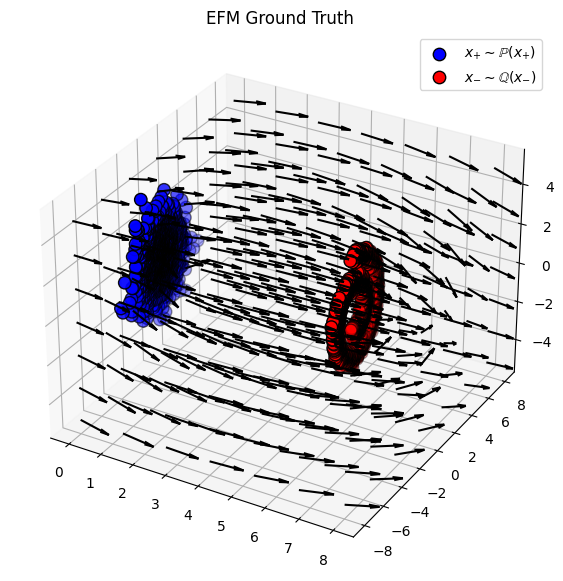

In [233]:
p_dist = MultiDimStackedGauss(config)
q_dist = SwissRollSampler(config)

p_samples = p_dist.sample(config.training.batch_size).to(config.device)
q_samples = q_dist.sample(config.training.batch_size).to(config.device)
efm = EFM(config)

mesh = efm.get_mesh(kv=config.KV,
                    mesh_num_points=config.mesh_num_points).to(config.device)
field = efm.GroundTruth(perturbed_samples_vec=mesh.clone(),
                        p_samples=p_samples, q_samples=q_samples)

fig = efm.plotVectorField(mesh=mesh, field=field,
                          p_samples=p_samples,
                          q_samples=q_samples)

In [140]:
config.ode.step = .5
config.ode.gamma = 0.
config.ode.behind_step = .025
config.ode.behind_num_steps = 650

In [141]:
ode = DippoleGroundTrurthEFMODESolver(config)
init = p_dist.sample(config.training.small_batch_size).to(config.device)
init[:,0] = config.training.epsilon
maps, traj = ode(efm, init , p_samples.clone(), q_samples.clone())
traj = torch.stack(traj,dim=0)

100%|██████████| 650/650 [00:00<00:00, 1027.84it/s]


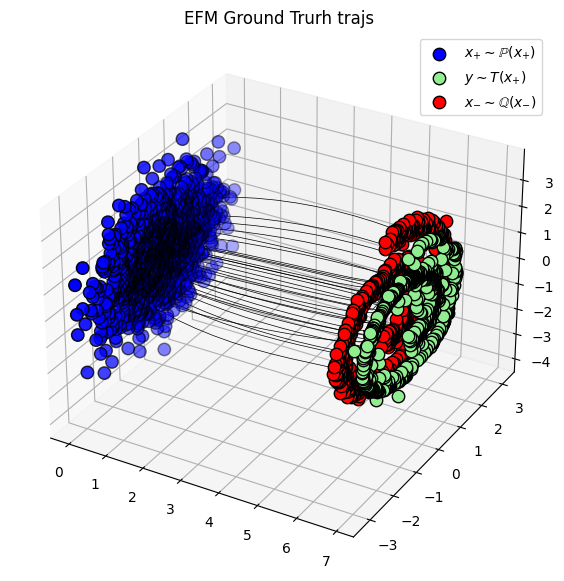

In [143]:
fig = efm.plotTrajectories(traj=traj, 
                           p_samples=p_samples,
                           q_samples=q_samples, title="EFM Ground Trurh trajs");